# KMC simulation of PLD with Deep Q Learning

In this versioin the state function is just the surface projection

In [1]:
!pip install keras

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install tensorflow-gpu

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import sys
import os
import numpy as np
import collections
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
target_roughness = 0.68 

In [5]:
#Writing some helper functions

def write_lattice_to_file(input_settings,position_vec, latt):
    #Write a new input lattice file
    #position_vec is the array containing positions of all of the atoms
    filename = input_settings['incfg_file'][0]
    new_latt_xyzs = list()
    
    for i in range(position_vec.shape[0]):
        new_latt_xyzs.append(list(['Ni', position_vec[i,0], position_vec[i,1],position_vec[i,2]]))

    new_latt = collections.OrderedDict()
    new_latt['nat'] = latt['nat']
    new_latt['box'] = latt['box']
    new_latt['xyzs'] = new_latt_xyzs

    write_latt(new_latt, filename)
    
    return 

def write_new_input_file(input_settings, filename):
    #Write a new input file, with settings laid out in the dictionary input_settings
    
    with open(filename, 'w') as fo:
        for key, val in input_settings.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)

def write_params_file(input_settings, new_parms):
    #IF you want to change parameters, use this function to write a new parameters file
    new_parms_file = input_settings['param_file']
    
    with open(new_parms_file, 'w') as fo:
        for key, val in new_parms.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)
            
def make_surface_proj(atom_box):
    #Given an atom box (matrix with 1s where atoms are), determine the surface projection
    
    surface_proj = np.zeros(shape=(atom_box.shape[0], atom_box.shape[1]))
    for i in range(surface_proj.shape[0]):
        for j in range(surface_proj.shape[1]):
            try:
                surface_proj[i,j] = np.max(np.where(atom_box[i,j,:]==1))
            except ValueError:
                surface_proj[i,j] = 0
    return surface_proj

def calc_roughness(surface_projection):
    #Calculate the roughness, given a surface projection
    N = surface_projection.shape[0]
    M = surface_projection.shape[1]
    zbar = np.mean(surface_projection)
    z_sum = 0
    for i in range(N):
        for j in range(M):
            z_sum+=((surface_projection[i,j] - zbar )**2)
    rms_roughness = np.sqrt((1.0/(N*M))*z_sum)
    return rms_roughness

def get_state_reward(sim_model):
    '''Given an input of the simulation model this function returns the state and reward'''
    #To get the final state put atoms into atom box
    arr = sim_model.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    reward = -1*np.sqrt((target_roughness-rms_val)**2) #penalty for straying from desired roughness.
    return surface_proj, reward

def run_sim_with_chosen_action(s,action,new_rates, verbose=False):
    #Given simulation model and the action, update the rate and continue running the simulation
    
    new_updated_rates = [new_rates[action[0]], new_rates[action[1]], new_rates[action[2]]]
    
    s.update_rate(np.array(new_updated_rates), verbose=verbose)
    
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99))
    
    #Now get the state and reward
    state, reward = get_state_reward(s)
            
    return state, reward, s,end_flag

In [6]:
#Need to hold the state in memory and hten 

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
sys.path.append('..') #/Users/l2v/work/kmcsim

Import kmc simulation tools

In [9]:
from kmcsim.buildtools import make_fcc, write_latt
from kmcsim.sim import KMCModel
from kmcsim.sim import EventTree
from kmcsim.sim import RunSim

Working directory (inputs, outputs)

In [10]:
wdir = '../data/working'

In [11]:
#cat ../data/working/params

Set up simulation box and initial configuration of the substrate (with atoms filling the whole box)

In [12]:
# make substrate: perfect FCC lattice of given dimensions
box = [16, 32, 4]
latt = make_fcc(box)

In [13]:
# extend the box in the z-direction to make space for new layers to grow
latt['box'][3] = 12

In [14]:
# write initial configuration to xyz file in the working directory
write_latt(latt, os.path.join(wdir,'ni.xyz'))

In [15]:
sim = RunSim()
sim.read(os.path.join(wdir,'kmc.input'))
sim.init_sim()
sim.run()

time, iteration, number of atoms
(0.0, 0, 2048)
(5.021810602522158, 123, 2160)
(10.0676376799706, 258, 2266)
(15.10010799606647, 398, 2374)
(20.124676198612832, 558, 2493)
(25.136637717613283, 720, 2609)
(30.15109971749087, 899, 2723)
(35.16895007948636, 1069, 2827)
(40.174256792920254, 1251, 2948)
(45.22190626765728, 1449, 3073)
(50.231919636687195, 1650, 3198)
(55.2361708629582, 1870, 3342)
End of simulation
(60.003442112818135, 2050, 3458)


current rates:[0.05 0.05 0.01] 
new rates:[0.12 0.12 0.12]
('kmc step:', 0)
current rates:[0.05 0.05 0.01] 
new rates:[0.14 0.12 0.12]
('kmc step:', 0)
current rates:[0.05 0.05 0.01] 
new rates:[0.16 0.12 0.12]
('kmc step:', 0)


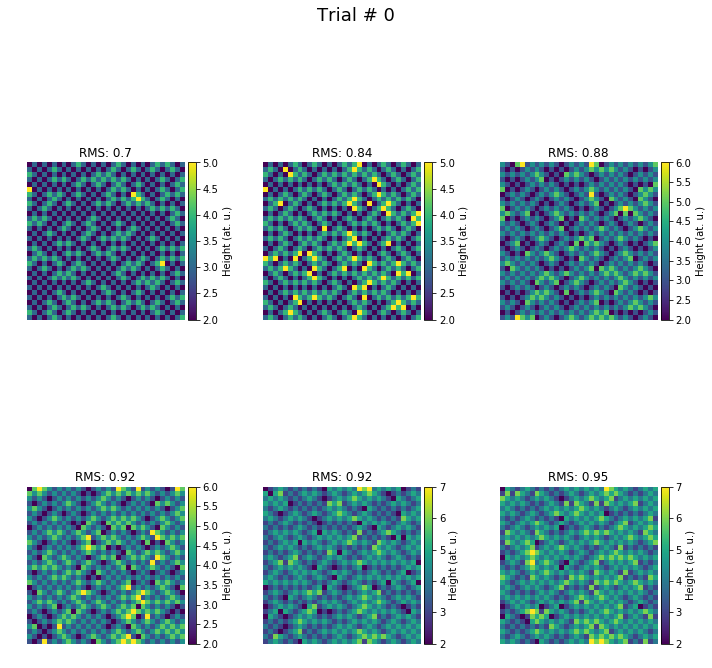

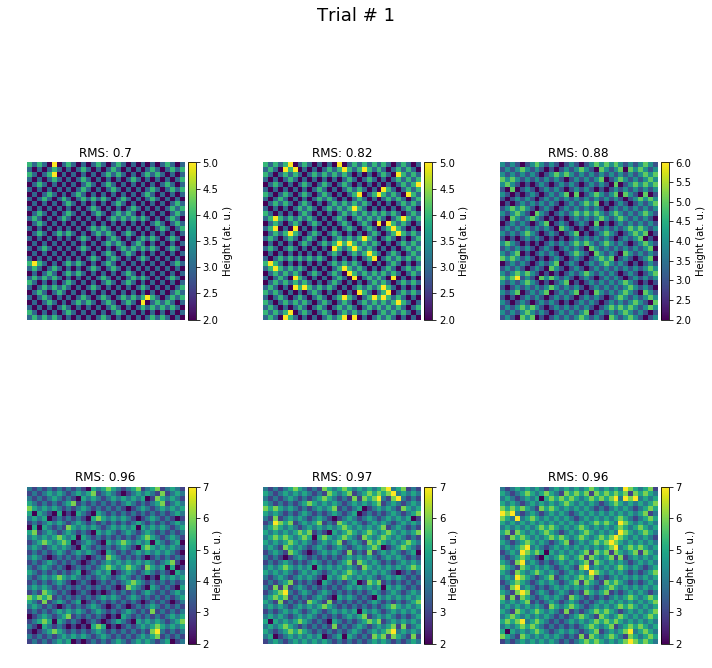

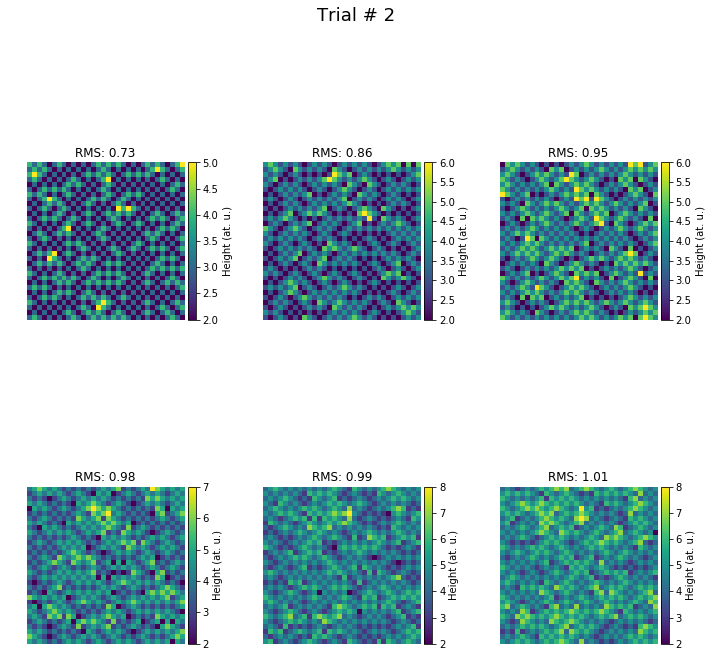

In [16]:
drates = [0.12, 0.14, 0.16]
deprates = [0.12, 0.12, 0.12]

arrs = []
roughness_values = []
for k in range(3):

    sim = RunSim()
    sim.read(os.path.join(wdir,'kmc.input'))
    sim.init_sim()
    sim.update_rate(np.array([drates[k], deprates[k], deprates[k]]))
    fig, axes = plt.subplots(figsize = (10,10), nrows=2,ncols=3)
    fig.suptitle("Trial # {}".format(k), fontsize = 18, y = 1.05)
    for ind, ax in enumerate(axes.flat):

        sim.run_to_next_step()
        arr = sim.kmc.get_conf()
        arr_1 = np.array(arr[0])
        arrs.append(arr_1)
        full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
        for i,j,k in arr_1:
            full_atom_box[i,j,k]=1

        surface_proj = make_surface_proj(full_atom_box)
        rms_val = calc_roughness(surface_proj)
        roughness_values.append(rms_val)
        im1 = ax.imshow(surface_proj)
        #plt.colorbar()
        ax.set_title('RMS: ' + str(np.round(rms_val,2)));
        ax.axis('off')
        #ax.set_yticklabels('')
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb = fig.colorbar(im1, cax=cax, orientation='vertical')
        cb.ax.set_ylabel('Height (at. u.)')
        
    fig.tight_layout(h_pad = 1.12, w_pad = 1.12)
    


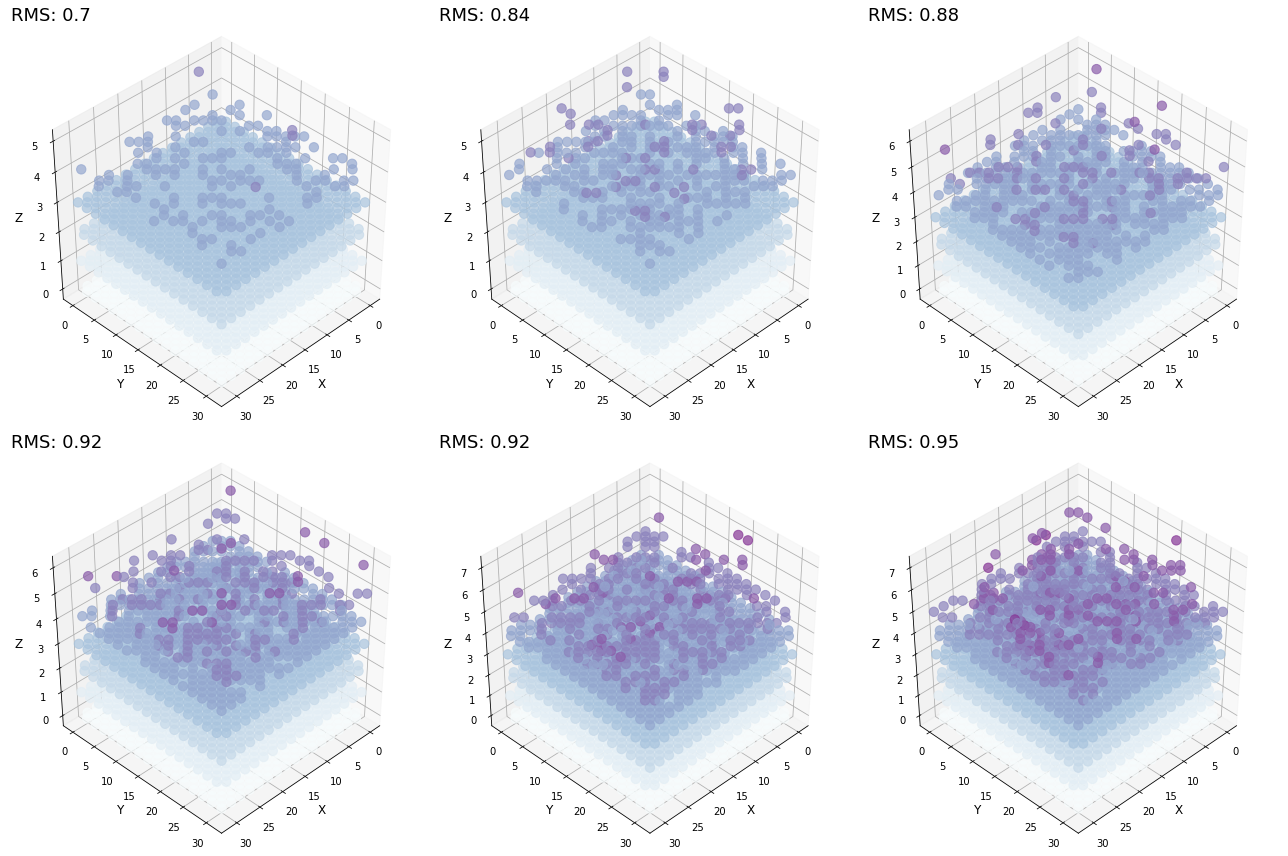

In [17]:
colors = plt.cm.get_cmap('BuPu', arr_1[:,2].max()*1.25)
arr_1 = arrs[5]

fig2, axes2 = plt.subplots(figsize = (18,12),nrows=2,ncols=3,subplot_kw=dict(projection='3d'))
for ind, ax in enumerate(axes2.flat):
    roughness_val = np.round(roughness_values[ind],2)
    arr_1 = arrs[ind]
    #ax = fig.add_subplot(111, projection='3d')
    ax.scatter(arr_1[:,0],arr_1[:,1],arr_1[:,2],s=88, alpha = 0.7, c = colors(arr_1[:,2]) )
    ax.view_init(40, 45)
    ax.set_xlabel('X', fontsize = 12)
    ax.set_ylabel('Y', fontsize = 12)
    ax.set_zlabel('Z', fontsize = 12)
    ax.set_title('RMS: {}'.format(roughness_val), loc = 'left', fontsize = 18)
fig2.tight_layout()

Text(0.5,1,'Roughness as Func. of Deposition Rates')

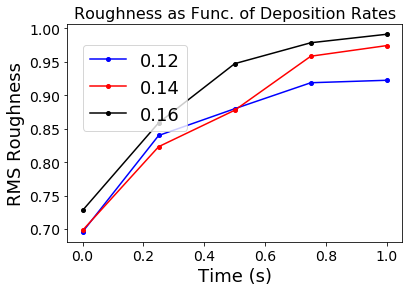

In [18]:
time_vec = np.linspace(0,1,5)

fig, axes = plt.subplots()
axes.plot(time_vec, roughness_values[:5], color = 'b', markersize = 4, marker = 'o',label = drates[0])
axes.plot(time_vec, roughness_values[6:11], color = 'r', markersize = 4, marker = 'o',label = drates[1])
axes.plot(time_vec, roughness_values[12:-1], color = 'k', markersize = 4, marker = 'o',label = drates[2])
axes.set_xlabel('Time (s)', fontsize = 18)
axes.set_ylabel('RMS Roughness', fontsize = 18)
fig.legend(loc=[0.2, 0.55], fontsize= 18)
for tickx in axes.xaxis.get_major_ticks():
    tickx.label.set_fontsize(14) 
for ticky in axes.yaxis.get_major_ticks():
    ticky.label.set_fontsize(14) 
axes.set_title('Roughness as Func. of Deposition Rates', fontsize = 16)
    

# Reinforcement Learning Trial

In [16]:
#Set up the neural network model. Input: atom position box. Output: 
#Choose out of 3  rates ([0.05, 0.1, 0.15]) for all three events. Vector of length 9.
from keras import Sequential
from keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Conv3D, MaxPool3D, Flatten
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, activation='relu', kernel_size = (3,3), strides = (1,1), batch_input_shape=(1,32,32,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(16, activation='relu', kernel_size = (3,3), strides = (1,1)))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.build()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (1, 30, 30, 32)           320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 15, 15, 32)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 13, 13, 16)           4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (1, 6, 6, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (1, 576)                  0         
_________________________________________________________________
dense_1 (Dense)              (1, 128)                  73856     
_________________________________________________________________
dense_2 (Dense)              (1, 128)                  16512     
__________

In [58]:
num_episodes = 50
y = 0.10
eps = 0.9
decay_factor = 0.99
r_avg_list = []
dep_rates = [0.05, 0.08, 0.11]
action_chosen = []

s = RunSim()
s.read(os.path.join(wdir,'kmc.input')) #Initialize the simulation with this input

for episode in range(num_episodes):
    t0 = time()
    if episode%10==0:
        print('Episode No. {}'.format(episode))
        
    counter = 0
    r_sum = 0
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    
    s.init_sim()
    s.update_rate(np.array([np.random.randint(low=1, high = 10)*0.03,
                           np.random.randint(low=1, high = 10)*0.03,
                           np.random.randint(low=1, high = 10)*0.03]), verbose=True)
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99)) #Run the simulation from the initial conditions
    
    
    
    while end_flag!=1:
        
        eps *= decay_factor
        #eps = max(eps, 0.05) #maintain some semblence of exploration ;)
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        if np.random.random() < eps:
            action = [np.random.randint(0, 3), np.random.randint(0, 3), np.random.randint(0, 3)]
            #Need to choose three actions at the same time.
        else:
            action = [np.argmax(model.predict(state[None,:,:,None])[0][:3]),
                      np.argmax(model.predict(state[None,:,:,None])[0][3:6]),
                      np.argmax(model.predict(state[None,:,:,None])[0][6:])]
            
        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        old_rates = s.kmc.etree.rates
        s_new, reward_new, kmc_model, end_flag = run_sim_with_chosen_action(s,action, dep_rates)
        
        #reward_new = reward_new - reward 
        
        target = reward_new + y * np.max(model.predict(s_new[None,:,:,None]))
        target_vec = model.predict(state[None,:,:,None])[0]
        target_vec[action] = target
        
        #print("Action Number: {}, Deposition Rate: {}".format(counter, dep_rates[action]))
        
        model.fit(state[None,:,:,None], target_vec.reshape(-1, 9), epochs=1, verbose=0)
        s = kmc_model
        counter+=1
        #r_sum.append(reward_new)
        
        action_chosen.append(action)
    t1 = time()    
    print("Took {} s".format(np.round(t1-t0, 4)))
        
    r_avg_list.append(reward_new)


Episode No. 0
current rates:[0.05 0.05 0.01] 
new rates:[0.24 0.06 0.18]
('kmc step:', 0)
Took 19.2819 s
current rates:[0.05 0.05 0.01] 
new rates:[0.15 0.09 0.09]
('kmc step:', 0)
Took 18.4314 s
current rates:[0.05 0.05 0.01] 
new rates:[0.18 0.06 0.21]
('kmc step:', 0)
Took 17.678 s
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.24 0.12]
('kmc step:', 0)
Took 14.1394 s
current rates:[0.05 0.05 0.01] 
new rates:[0.21 0.15 0.27]
('kmc step:', 0)
Took 16.0559 s
current rates:[0.05 0.05 0.01] 
new rates:[0.24 0.03 0.24]
('kmc step:', 0)
Took 15.5353 s
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.27 0.06]
('kmc step:', 0)
Took 13.1985 s
current rates:[0.05 0.05 0.01] 
new rates:[0.09 0.21 0.03]
('kmc step:', 0)
Took 15.6542 s
current rates:[0.05 0.05 0.01] 
new rates:[0.09 0.09 0.27]
('kmc step:', 0)
Took 15.0043 s
current rates:[0.05 0.05 0.01] 
new rates:[0.27 0.15 0.09]
('kmc step:', 0)
Took 12.5617 s
current rates:[0.05 0.05 0.01] 
new rates:[0.18 0.12 0.27]
('kmc step:', 0)
T

Took 10.6577 s
current rates:[0.05 0.05 0.01] 
new rates:[0.27 0.06 0.18]
('kmc step:', 0)
Took 12.503 s
current rates:[0.05 0.05 0.01] 
new rates:[0.24 0.24 0.18]
('kmc step:', 0)
Took 12.4924 s
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.27 0.12]
('kmc step:', 0)
Took 9.7917 s
current rates:[0.05 0.05 0.01] 
new rates:[0.09 0.06 0.27]
('kmc step:', 0)
Took 11.2545 s
Episode No. 100
current rates:[0.05 0.05 0.01] 
new rates:[0.24 0.21 0.06]
('kmc step:', 0)
Took 11.9059 s
current rates:[0.05 0.05 0.01] 
new rates:[0.09 0.21 0.03]
('kmc step:', 0)
Took 10.7008 s
current rates:[0.05 0.05 0.01] 
new rates:[0.15 0.15 0.18]
('kmc step:', 0)
Took 11.1594 s
current rates:[0.05 0.05 0.01] 
new rates:[0.24 0.15 0.06]
('kmc step:', 0)
Took 12.19 s
current rates:[0.05 0.05 0.01] 
new rates:[0.15 0.24 0.09]
('kmc step:', 0)
Took 10.8867 s
current rates:[0.05 0.05 0.01] 
new rates:[0.18 0.15 0.24]
('kmc step:', 0)
Took 12.0135 s
current rates:[0.05 0.05 0.01] 
new rates:[0.09 0.12 0.12]
('km

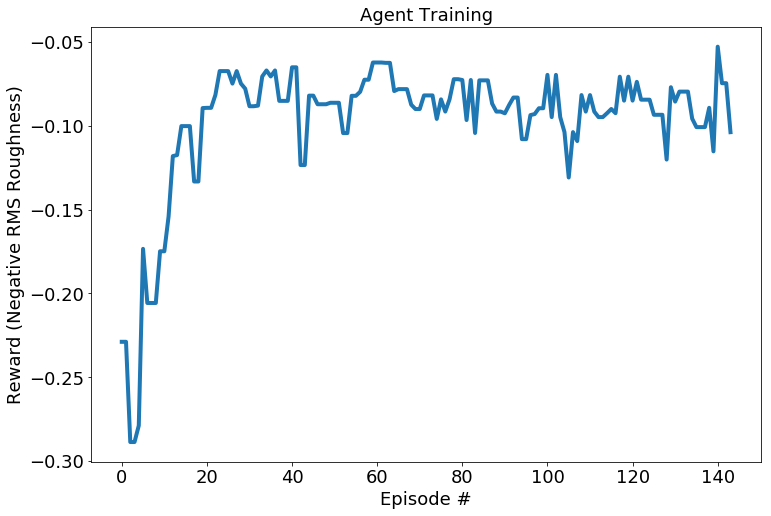

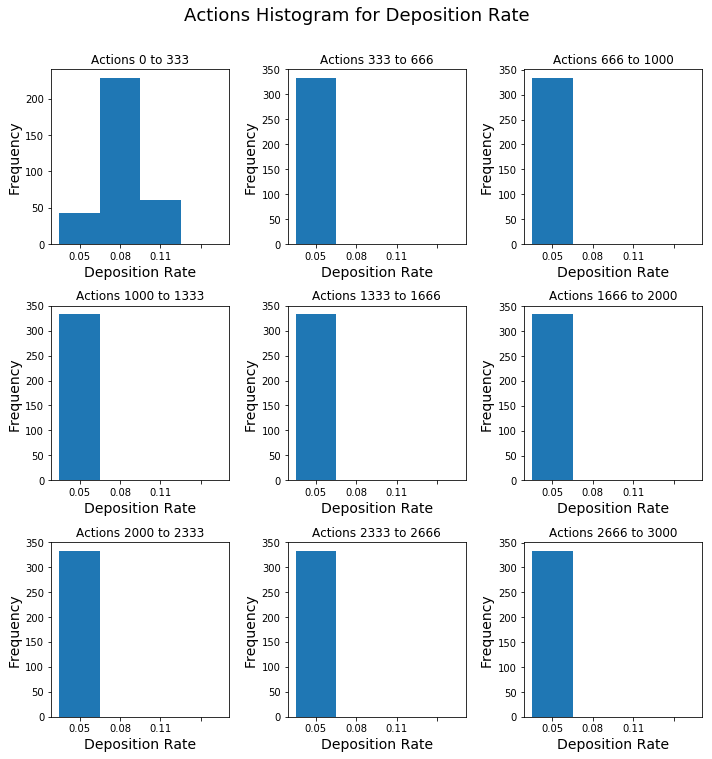

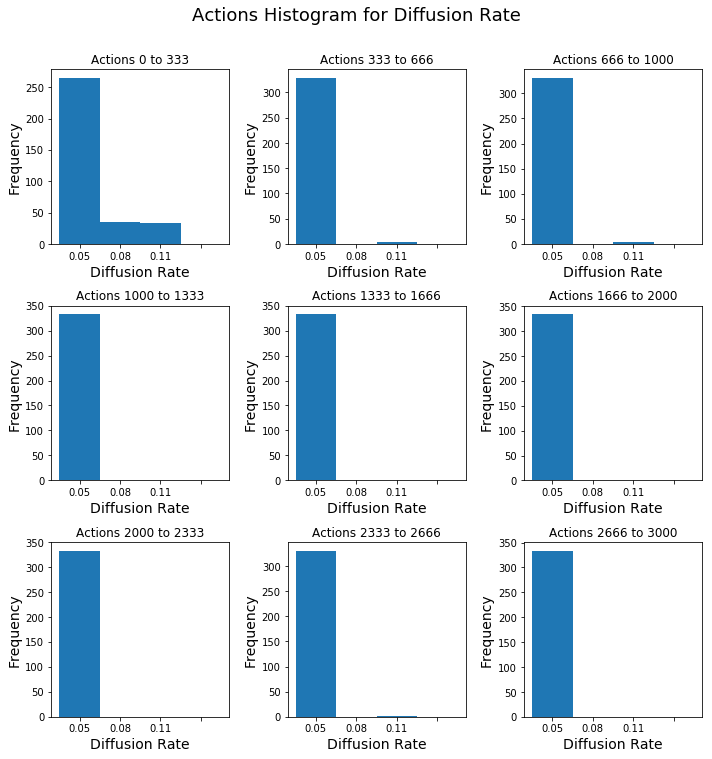

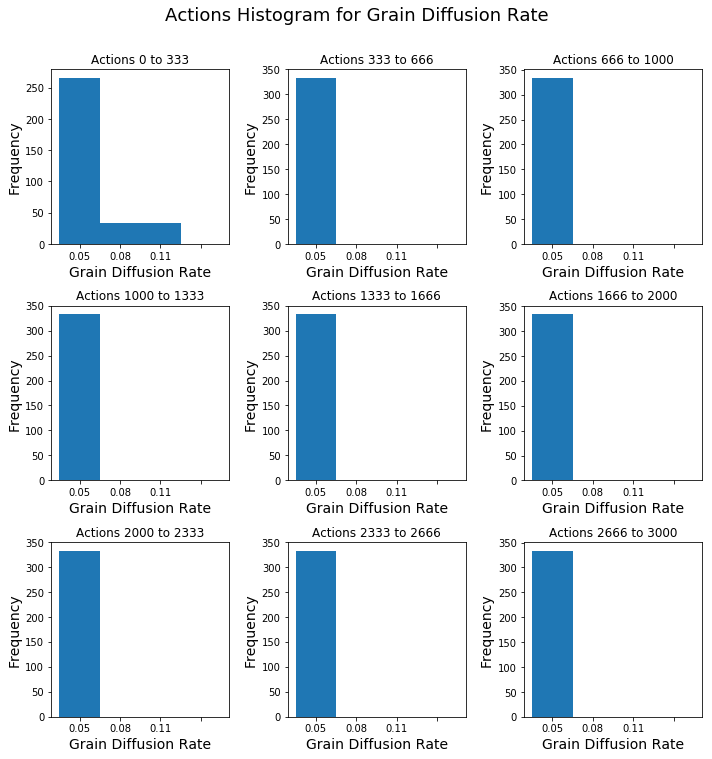

In [59]:
r_avg_list = np.array(r_avg_list).ravel()
from scipy.signal import wiener, medfilt

kernel_size = 3

plt.figure(figsize = (12,8))
plt.plot(medfilt(r_avg_list, kernel_size= kernel_size)[kernel_size:-kernel_size], linewidth = 4)
plt.title('Agent Training', fontsize = 18)
plt.xlabel('Episode #', fontsize = 18)
plt.ylabel('Reward (Negative RMS Roughness)', fontsize = 18)
plt.xticks(fontsize =18)
plt.yticks(fontsize =18)
plt.savefig('reward_per_episode_dep_sp.png', dpi = 300)

#Let's take a look at how the actions change over time: consider 9 increments

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

rate_labels = ['Deposition Rate', 'Diffusion Rate', 'Grain Diffusion Rate']

for i in range(3):
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
    for ind, ax in enumerate(axes.flat):
        seg_start = int(segments[ind])
        seg_finish = min(int(segments[ind+1]),total_actions)
        act_segment = np.array(action_chosen[seg_start:seg_finish])[:,i] 
       
        ax.hist(act_segment, bins = [0,1,2,3,4])
        ax.set_xlabel(rate_labels[i], fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(dep_rates)

    fig.suptitle('Actions Histogram for ' + rate_labels[i], fontsize = 18, y = 1.05)
    fig.tight_layout()
    fig.savefig('actions_histogram_dep_sp_'+str(i) +'.png', dpi = 300)

#### things to try
#1. 2d conv net with surface projection
#2. flattened array with xyz values instead of whole box
#3. find time taken per simulation (as above)

1. distributed learning.
2. try more sophisticated algo.
3. keep on getting closer to PLD...


# Policy Evaluation

In [60]:
#Let's see what the roughness actually is for the policy
num_episodes = 20
r_avg_list = []
action_chosen = []

for episode in range(num_episodes):
    t0 = time()
    if episode%5==0:
        print('Episode No. {}'.format(episode))
        
    counter = 0
    r_sum = []
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    
    s.init_sim()
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99)) #Run the simulation from the initial conditions
    
    while end_flag!=1:
        
        eps *= decay_factor
        #eps = max(eps, 0.05) #maintain some semblence of exploration ;)
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        
        action = [np.argmax(model.predict(state[None,:,:,None])[0][:3]),
                  np.argmax(model.predict(state[None,:,:,None])[0][3:6]),
                  np.argmax(model.predict(state[None,:,:,None])[0][6:])]
            
        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        old_rates = s.kmc.etree.rates
        s_new, reward_new, kmc_model, end_flag = run_sim_with_chosen_action(s,action, dep_rates)

        s = kmc_model
        counter+=1
        r_sum.append(reward_new)
        
        action_chosen.append(action)
    t1 = time()    
    print("Took {} s".format(np.round(t1-t0, 4)))
        
    r_avg_list.append(reward_new)

Episode No. 0
Took 10.2397 s
Took 10.2292 s
Took 10.272 s
Took 9.8162 s
Took 10.2555 s
Episode No. 5
Took 10.5033 s
Took 9.9167 s
Took 10.2897 s
Took 10.3161 s
Took 10.003 s
Episode No. 10
Took 10.0886 s
Took 10.1542 s
Took 10.1074 s
Took 10.634 s
Took 10.2694 s
Episode No. 15
Took 10.0988 s
Took 9.4643 s
Took 10.5774 s
Took 9.8788 s
Took 10.0543 s


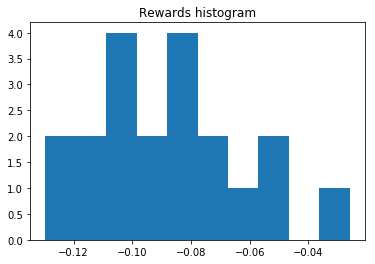

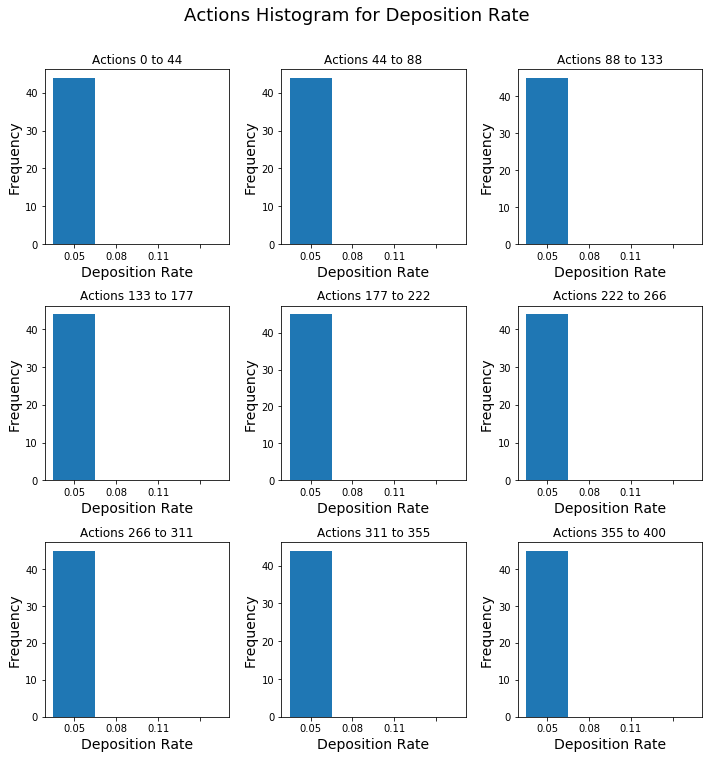

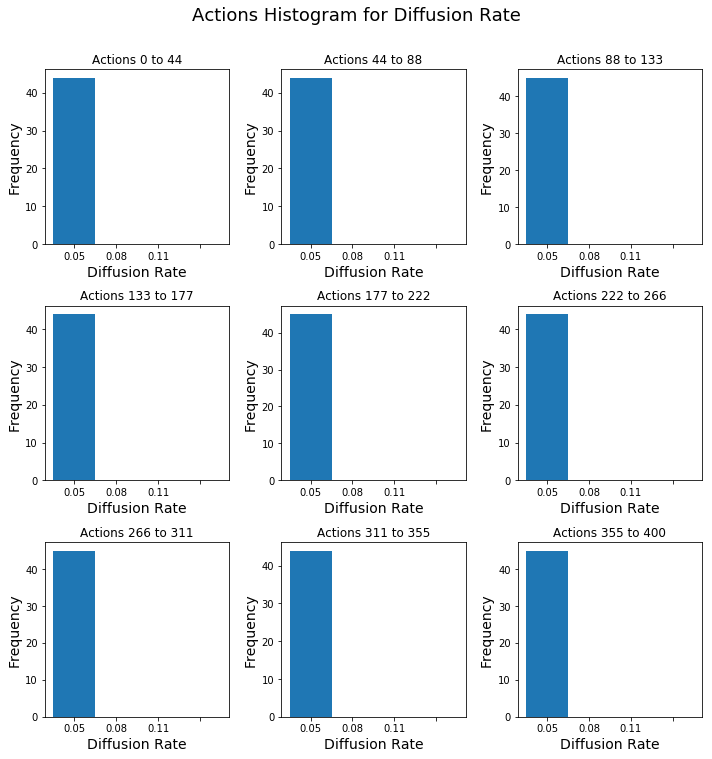

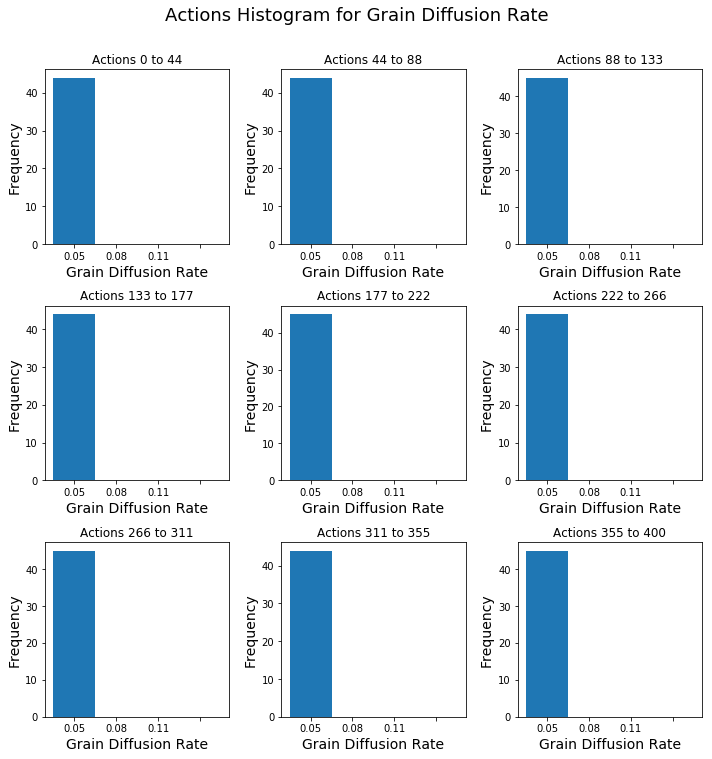

In [61]:
r = np.array(r_avg_list)
plt.figure()
plt.hist(r.ravel())
plt.title('Rewards histogram')

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

for i in range(3):
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
    for ind, ax in enumerate(axes.flat):
        seg_start = int(segments[ind])
        seg_finish = min(int(segments[ind+1]),total_actions)
        act_segment = np.array(action_chosen[seg_start:seg_finish])[:,i] 
       
        ax.hist(act_segment, bins = [0,1,2,3,4])
        ax.set_xlabel(rate_labels[i], fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(dep_rates)

    fig.suptitle('Actions Histogram for ' + rate_labels[i], fontsize = 18, y = 1.05)
    fig.tight_layout()

In [62]:
# Compare with Random policy
#Let's see what the roughness actually is for the policy
num_episodes = 20
r_avg_list = []
action_chosen = []

for episode in range(num_episodes):
    t0 = time()
    if episode%5==0:
        print('Episode No. {}'.format(episode))
        
    counter = 0
    r_sum = []
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    
    s.init_sim()
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99)) #Run the simulation from the initial conditions
    
    while end_flag!=1:
        
        
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        
        action = [np.random.randint(0, 3), np.random.randint(0, 3), np.random.randint(0, 3)]
            
        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        old_rates = s.kmc.etree.rates
        s_new, reward_new, kmc_model, end_flag = run_sim_with_chosen_action(s,action, dep_rates)

        s = kmc_model
        counter+=1
        r_sum.append(reward_new)
        
        action_chosen.append(action)
    t1 = time()    
    print("Took {} s".format(np.round(t1-t0, 4)))
        
    r_avg_list.append(reward_new)

Episode No. 0
Took 14.4225 s
Took 16.9882 s
Took 15.7388 s
Took 15.8116 s
Took 17.5127 s
Episode No. 5
Took 16.5179 s
Took 17.1142 s
Took 17.6785 s
Took 15.7055 s
Took 17.6232 s
Episode No. 10
Took 15.0573 s
Took 16.6754 s
Took 19.1755 s
Took 15.7068 s
Took 16.9343 s
Episode No. 15
Took 17.0127 s
Took 19.2672 s
Took 16.9456 s
Took 18.4185 s
Took 18.4149 s


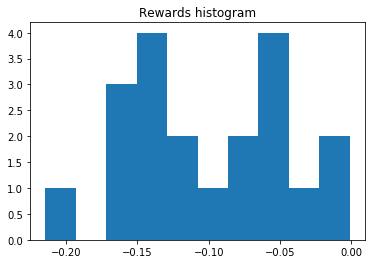

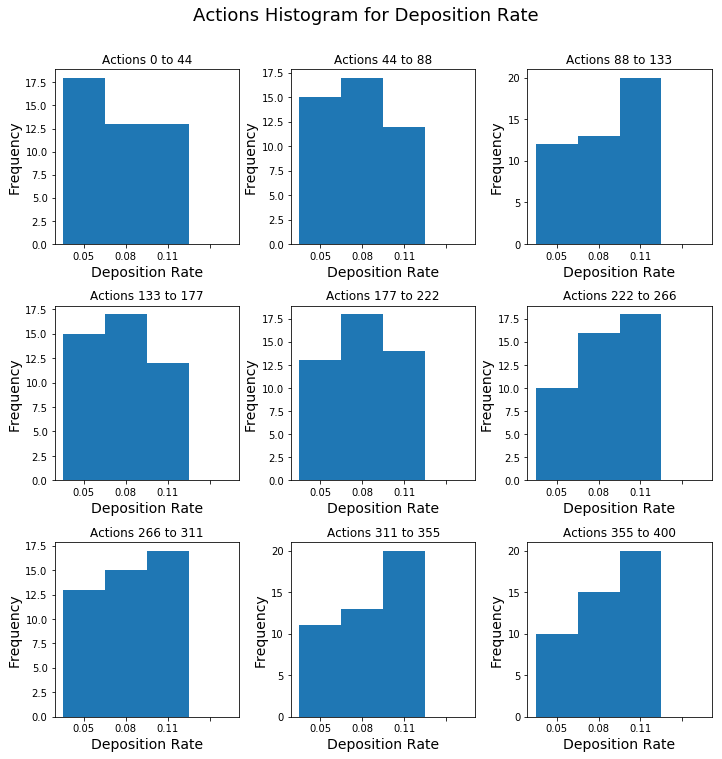

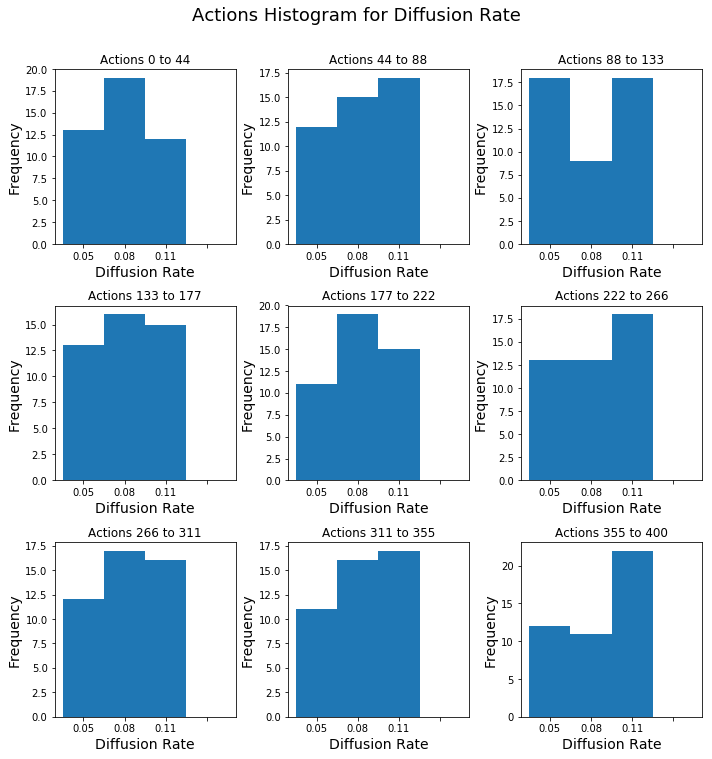

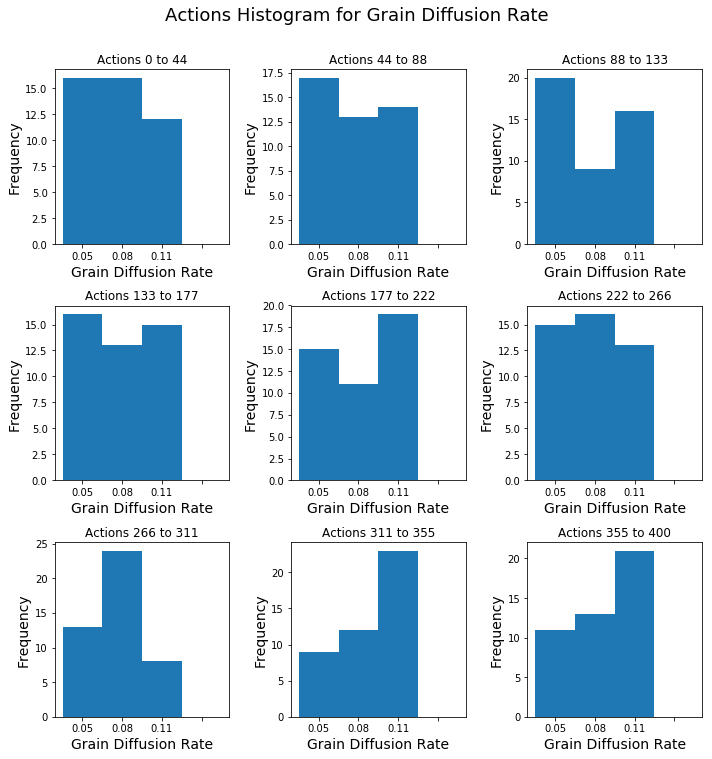

In [63]:
r = np.array(r_avg_list)
plt.figure()
plt.hist(r.ravel())
plt.title('Rewards histogram')

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

for i in range(3):
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
    for ind, ax in enumerate(axes.flat):
        seg_start = int(segments[ind])
        seg_finish = min(int(segments[ind+1]),total_actions)
        act_segment = np.array(action_chosen[seg_start:seg_finish])[:,i] 
       
        ax.hist(act_segment, bins = [0,1,2,3,4])
        ax.set_xlabel(rate_labels[i], fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(dep_rates)

    fig.suptitle('Actions Histogram for ' + rate_labels[i], fontsize = 18, y = 1.05)
    fig.tight_layout()